# demo_lenspyx

This notebook shows how to generate lensed CMB maps with DUCC-based lenspyx on pixelized skies ([this paper](https://arxiv.org/abs/2304.10431)).

The map constructions in this notebook should take $\mathcal O$(seconds) on a modern laptop.

We test here

    lenspyx.alm2lenmap, lenspyx.alm2lenmap_spin, lenspyx.synfast

This last function is what you want if you just need to generate lensed CMB skies from scratch.

For other stuff lenspyx.tests might contain other useful scripts or you can contact me

In [1]:
%matplotlib inline
import os
import pylab as pl
import numpy as np
import lenspyx

In [2]:
# We first generate an unlensed temperature and lensing potential. 
# Here for simplicity we use synalm, neglecting correlations between T, E and phi.

from lenspyx.utils import camb_clfile
from lenspyx.utils_hp import synalm, almxfl, alm2cl

lmax_len = 3000 # desired lmax of the lensed field.
dlmax = 1024  # lmax of the unlensed fields is lmax + dlmax.  (some buffer is required for accurate lensing at lmax)
epsilon = 1e-6 # target accuracy of the output maps (execution time has a fairly weak dependence on this)
lmax_unl, mmax_unl = lmax_len + dlmax, lmax_len + dlmax

cls_path = os.path.join(os.path.dirname(os.path.abspath(lenspyx.__file__)), 'data', 'cls')

cl_len = camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lensedCls.dat'))
cl_unl = camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lenspotentialCls.dat'))

tlm_unl = synalm(cl_unl['tt'], lmax=lmax_unl, mmax=mmax_unl)
elm_unl = synalm(cl_unl['ee'], lmax=lmax_unl, mmax=mmax_unl)
blm_unl = synalm(cl_unl['bb'], lmax=lmax_unl, mmax=mmax_unl)

plm = synalm(cl_unl['pp'], lmax=lmax_unl, mmax=mmax_unl)

# We then transform the lensing potential into spin-1 deflection field, and deflect the temperature map.
dlm = almxfl(plm, np.sqrt(np.arange(lmax_unl + 1, dtype=float) * np.arange(1, lmax_unl + 2)), None, False)

In [3]:
# Geometry on which to produce the lensed map
geom_info = ('healpix', {'nside':2048}) # here we will use an Healpix grid with nside 2048

# Unlensed T map is this:
geom = lenspyx.get_geom(geom_info)
Tunl = geom.alm2map(tlm_unl, lmax_unl, mmax_unl, nthreads=os.cpu_count())

alm2lenmap: using 8 nthreads
  build angles <- synthesis (GRAD_ONLY):  [0:00:02.602197] (32.7%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.599993] (7.5%)  
  build_angles                         :  [0:00:03.202209] (40.3%)  
  synthesis general (STANDARD)         :  [0:00:04.549906] (57.2%)  
  gclm2lenmap                          :  [0:00:07.837899] (98.6%)  
  polrot (ducc)                        :  [0:00:00.085709] (1.1%)  
  Total                                :  [0:00:07.949064] d:h:m:s:mus


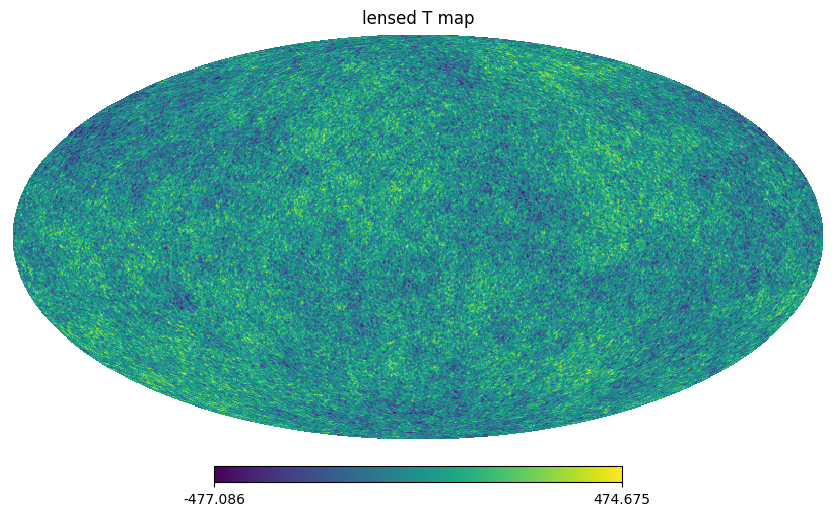

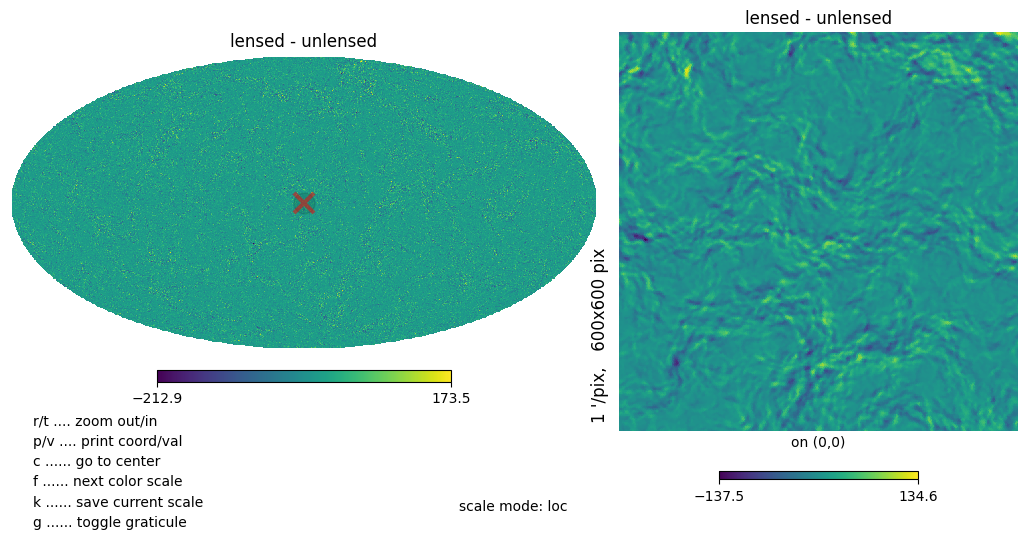

In [4]:
# Lensed T and Pol. maps:
Tlen, Qlen, Ulen = lenspyx.alm2lenmap([tlm_unl, elm_unl, blm_unl], dlm, geometry=geom_info, verbose=1, epsilon=epsilon)

try:
    import healpy as hp
    hp.mollview(Tlen, title='lensed T map')
    hp.mollzoom(Tlen -Tunl, title='lensed - unlensed')
except:
    pass

In [5]:
# The unlensed B-mode was zero, we could have used this just as well, with in principle slightly faster results in the polarisation step
Tlen, Qlen, Ulen = lenspyx.alm2lenmap([tlm_unl, elm_unl], dlm, geometry=geom_info, verbose=1)

alm2lenmap: using 8 nthreads
  build angles <- synthesis (GRAD_ONLY):  [0:00:02.888735] (35.6%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.649238] (8.0%)  
  build_angles                         :  [0:00:03.537993] (43.7%)  
  synthesis general (STANDARD)         :  [0:00:01.556886] (19.2%)  
  gclm2lenmap                          :  [0:00:08.047175] (99.3%)  
  synthesis general (GRAD_ONLY)        :  [0:00:02.868423] (35.4%)  
  polrot (ducc)                        :  [0:00:00.083831] (1.0%)  
  Total                                :  [0:00:08.103322] d:h:m:s:mus


In [6]:
# T-P independent constructions (redundant angle construction work for T and P)
Tlen = lenspyx.alm2lenmap(tlm_unl, dlm, geometry=geom_info, verbose=1)
Qlen, Ulen = lenspyx.alm2lenmap_spin(elm_unl, dlm, 2, geometry=geom_info, verbose=1)

alm2lenmap: using 8 nthreads
  build angles <- synthesis (GRAD_ONLY):  [0:00:03.083632] (58.0%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.623314] (11.7%)  
  build_angles                         :  [0:00:03.706979] (69.8%)  
  synthesis general (STANDARD)         :  [0:00:01.607354] (30.2%)  
  gclm2lenmap                          :  [0:00:05.314355] (100.0%)  
  Total                                :  [0:00:05.314433] d:h:m:s:mus
alm2lenmap_spin: using 8 nthreads
  build angles <- synthesis (GRAD_ONLY):  [0:00:03.176353] (45.3%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.630457] (9.0%)  
  build_angles                         :  [0:00:03.806864] (54.3%)  
  synthesis general (GRAD_ONLY)        :  [0:00:03.112805] (44.4%)  
  polrot (ducc)                        :  [0:00:00.087658] (1.3%)  
  gclm2lenmap                          :  [0:00:07.007324] (100.0%)  
  Total                                :  [0:00:07.007391] d:h:m:s:mus


In [ ]:
# To add a curl deflection, can just do this: (here taking curl equal to phi for fun)
clm = dlm.copy() # here taking curl equal to phi and setting gradient to zero just for fun
Tlen = lenspyx.alm2lenmap(tlm_unl, [dlm * 0., clm], geometry=geom_info, verbose=1)
try:
    hp.mollview(Tlen, title='curl-lensed T map')
    hp.mollzoom(Tlen -Tunl, title='lensed - unlensed')
except:
    pass

alm2lenmap: using 8 nthreads


In [ ]:
# Other geometries: thinned Gauss-Legendre is often a good choice since in contrast to healpix it gives good quadrature with economy of rings:
gl_geom_info = ('thingauss', {'smax': 2, 'lmax':lmax_unl})  # increase lmax here to get more accurate quadrature
Tlen, Qlen, Ulen  = lenspyx.alm2lenmap([tlm_unl, elm_unl], dlm, geometry=gl_geom_info, verbose=1)

In [ ]:
# Let's go back to Fourier space and build spectra
gl_geom = lenspyx.get_geom(gl_geom_info)
elm_len, blm_len = gl_geom.map2alm_spin([Qlen, Ulen], 2, lmax_len, lmax_len, nthreads=os.cpu_count())
tlm_len = gl_geom.map2alm(Tlen, lmax_len, lmax_len, nthreads=os.cpu_count()) # (Be aware that geom.map2alm will in general modify the input map, multplying it by the quadrature weights)

# plots against pred
fig,axes = pl.subplots(2, 1)
clbb_len = alm2cl(blm_len, blm_len, lmax_len, lmax_len, lmax_len) # Same as hp.alm2cl
ls = np.arange(2, lmax_len + 1)
pl.sca(axes[0])
pl.loglog(ls, clbb_len[ls], label='BB')
pl.plot(ls, cl_len['bb'][ls], c='k')
pl.legend()
pl.sca(axes[1])
cltt_len = alm2cl(tlm_len, tlm_len, lmax_len, lmax_len, lmax_len)
clee_len = alm2cl(elm_len, elm_len, lmax_len, lmax_len, lmax_len)
pl.plot(ls, cltt_len[ls]/ cl_unl['tt'][ls], label='TT')
pl.plot(ls, cl_len['tt'][ls]/ cl_unl['tt'][ls], c='k')
pl.plot(ls, clee_len[ls]/ cl_unl['ee'][ls], label='EE')
pl.plot(ls, cl_len['ee'][ls]/ cl_unl['ee'][ls], c='k', ls='--')
pl.ylim(0.8, 1.4)
pl.legend()

In [ ]:
# Available geometries, custom geoms can easily be added, check code there
from lenspyx.remapping.utils_geom import Geom
Geom.show_supported_geometries()

In [ ]:
# Finally, synfast will build a realization of the lensed maps for you from scratch
from lenspyx import synfast

cl_unl = camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lenspotentialCls.dat'))
geom_info = ('healpix', {'nside':2048}) # Geometry parametrized as above, this is the default
maps = synfast(cl_unl, lmax=lmax_unl, verbose=1, geometry=geom_info)
# Generations of the unlensed will include all correlations as given in the cl_unl dictionary
# Feed-in alm=True to return the unlensed alm as well
try:
    import healpy as hp
    hp.mollzoom(maps['T'], title='T')
    hp.mollzoom(maps['QU'][0], title='Q')
    hp.mollzoom(maps['QU'][1], title='U')

except:
    pass
